In [3]:
import pandas as pd
from shapely.geometry import Point
import elapid as ela
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import os
import rasterio
from rasterio.mask import mask
import rasterio.plot
import numpy as np
from sklearn import metrics

mpl.style.use("ggplot")
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

### Load data and retrain full model

In [4]:
data = pd.read_csv("./location_climate_data.csv")
data = data.drop(columns=["Unnamed: 0"])
columns_to_drop = [
    "ai",
    "kg0",
    "kg1",
    "kg2",
    "kg3",
    "kg4",
    "kg5",
    "clt_max",
    "clt_mean",
    "clt_min",
    "clt_range",
    "cmi_max",
    "cmi_mean",
    "cmi_min",
    "cmi_range",
    "gdd5",
    "gddlgd5",
    "gdgfgd5",
    "ngd5",
    "sfcWind_max",
    "sfcWind_mean",
    "sfcWind_min",
    "sfcWind_range",
    "swb",
    "swe",
    "vpd_max",
    "vpd_mean",
    "vpd_min",
    "vpd_range",
]
data = data.drop(columns=columns_to_drop)
data.columns

C:\Users\Maggie\AppData\Local\Temp\ipykernel_11756\1009146240.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("./location_climate_data.csv")


Index(['lat', 'long', 'uuid', 'label', 'bio10', 'bio11', 'bio12', 'bio13',
       'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1', 'bio2',
       'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf', 'fgd',
       'gdd0', 'gdd10', 'gddlgd0', 'gddlgd10', 'gdgfgd0', 'gdgfgd10', 'gsl',
       'gsp', 'gst', 'hurs_max', 'hurs_mean', 'hurs_min', 'hurs_range', 'lgd',
       'ngd0', 'ngd10', 'npp', 'pet_penman_max', 'pet_penman_mean',
       'pet_penman_min', 'pet_penman_range', 'rsds_max', 'rsds_mean',
       'rsds_min', 'rsds_range', 'scd'],
      dtype='object')

In [5]:
# Modify feature columns
feature_cols = [
    "bio10",
    "bio11",
    "bio12",
    "bio13",
    "bio14",
    "bio15",
    "bio16",
    "bio17",
    "bio18",
    "bio19",
    "bio1",
    "bio2",
    "bio3",
    "bio4",
    "bio5",
    "bio6",
    "bio7",
    "bio8",
    "bio9",
]

In [6]:
# Convert presence points to binary classification
data["class"] = data["label"].apply(lambda x: 1 if x == "kikuyugrass" else 0)

# Create geodataframe
geometry = [Point(xy) for xy in zip(data["long"], data["lat"])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

# Split into presence absence and convert distance weights
presence = gdf[gdf["class"] == 1]
background = gdf[gdf["class"] == 0]

presence["SampleWeight"] = ela.distance_weights(presence, n_neighbors=1)
background["SampleWeight"] = ela.distance_weights(background, n_neighbors=1)

# Prep for modeling
merged = ela.stack_geodataframes(
    presence,
    background,
    add_class_label=True,
)

x = merged[feature_cols].copy()
y = merged["class"]
sample_weight = merged["SampleWeight"]

model = ela.MaxentModel()
final_model = ela.MaxentModel()
final_model.fit(
    x,
    y,
    # sample_weight=sample_weight
)
ypred = final_model.predict(x)
full_auc = metrics.roc_auc_score(y, ypred)
print(f"Full model AUC: {full_auc:0.3f}")

c:\Users\Maggie\AppData\Local\Programs\Python\Python312\Lib\site-packages\elapid\geo.py:865: UserWarning: Computing distances using geographic coordinates is bad
  warnings.warn("Computing distances using geographic coordinates is bad")
c:\Users\Maggie\AppData\Local\Programs\Python\Python312\Lib\site-packages\elapid\geo.py:865: UserWarning: Computing distances using geographic coordinates is bad
  warnings.warn("Computing distances using geographic coordinates is bad")


Full model AUC: 0.984


### Clip the global rasters to our extent

In [7]:
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)
california = us_states[us_states["NAME"] == "California"]
california_border = california.dissolve()

raster_names = [
    f
    for f in os.listdir("./climate_data")
    if f.startswith("CHELSA") and f.endswith(".tif")
]
global_rasters = [f"./climate_data/{raster}" for raster in raster_names]

os.makedirs("./climate_data_clipped", exist_ok=True)

clipped_rasters = []
for raster in global_rasters:
    clipped_raster = raster.replace("climate_data", "climate_data_clipped")

    if os.path.exists(clipped_raster):
        print(f"Clipped raster already exists: {clipped_raster}")
        clipped_rasters.append(clipped_raster)
        continue

    try:
        with rasterio.open(raster) as src:
            print(f"\nProcessing: {raster}")
            print(f"Original dtype: {src.dtypes[0]}")
            print(f"Original nodata: {src.nodata}")

            california_border_reprojected = california_border.to_crs(src.crs)
            geoms = california_border_reprojected.geometry.values

            out_image, out_transform = mask(
                src,
                geoms,
                crop=True,
                nodata=src.nodata,  # Use source nodata value
                all_touched=True,  # Include cells that are touched by the geometry
            )
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "dtype": src.dtypes[0],
                    "nodata": src.nodata,
                }
            )

            with rasterio.open(clipped_raster, "w", **out_meta) as dest:
                dest.write(out_image)

            with rasterio.open(clipped_raster) as clipped:
                data = clipped.read(1)
                print(f"Output stats:")
                print(f"Min: {np.min(data[data != clipped.nodata])}")
                print(f"Max: {np.max(data[data != clipped.nodata])}")
                print(f"Mean: {np.mean(data[data != clipped.nodata])}")

            clipped_rasters.append(clipped_raster)
    except Exception as e:
        print(f"Error processing {raster}: {str(e)}")

print(f"Processing complete. {len(clipped_rasters)} rasters processed.")

Clipped raster already exists: ./climate_data_clipped/CHELSA_ai_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio10_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio11_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio12_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio13_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio14_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio15_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio16_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio17_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio18_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_clipped/CHELSA_bio19_1981-2010_V.2.1.tif
Clipped raster already exists: ./climate_data_

In [ ]:
# Load just Hawaii
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)
hawaii = us_states[us_states["NAME"] == "Hawaii"]
hawaii_border = hawaii.dissolve()

In [ ]:
# Load CONUS states only
url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip"
us_states = gpd.read_file(url)
# Exclude territories, Alaska, and Hawaii
excluded = [
    "American Samoa",
    "Guam",
    "Northern Mariana Islands",
    "Puerto Rico",
    "United States Virgin Islands",
    "Alaska",
    "Hawaii",
]
conus = us_states[~us_states["NAME"].isin(excluded)]
conus_border = conus.dissolve()

### Generate prediction map

In [8]:
def get_var_name(filepath):
    filename = os.path.basename(filepath)
    # special cases first
    if "rsds_1981-2010" in filename:
        for suffix in ["max", "mean", "min", "range"]:
            if f"rsds_1981-2010_{suffix}" in filename:
                return f"rsds_{suffix}"
    var_name = filename.split("CHELSA_")[1].split("_1981")[0]
    return var_name


# only include those in feature_list
model_rasters = [
    raster for raster in clipped_rasters if get_var_name(raster) in feature_cols
]
output_raster = os.path.join("kikuyugrass_predictions.tif")
ela.apply_model_to_rasters(final_model, model_rasters, output_raster, quiet=False)

Window:   0%|                              | 0/380 [00:00<?, ?it/s]

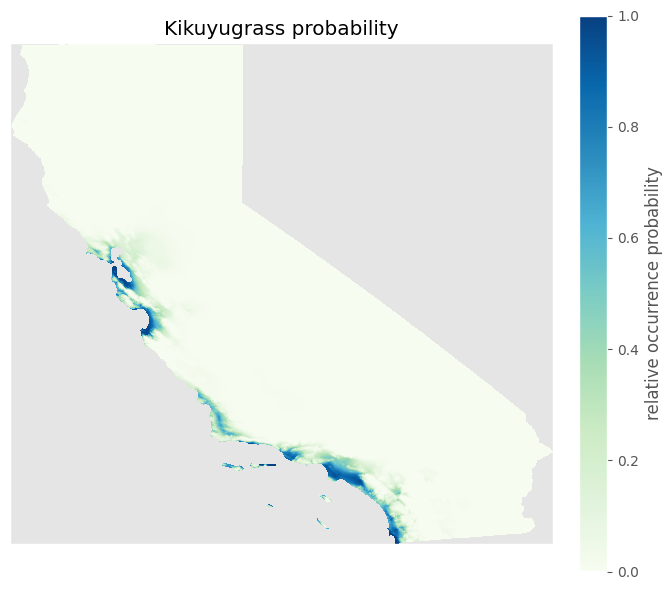

In [17]:
with rasterio.open(output_raster, "r") as src:
    pred = src.read(1, masked=True)
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap="GnBu")
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

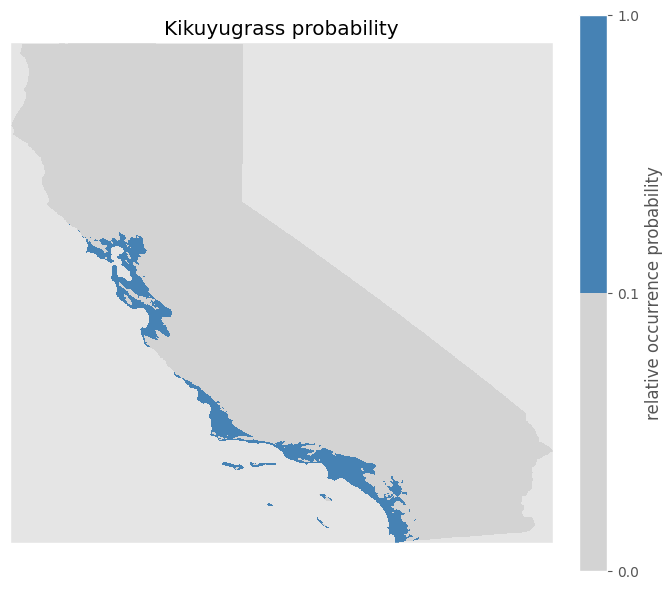

In [10]:
with rasterio.open(output_raster, "r") as src:
    pred = src.read(1, masked=True)

colors = ["lightgray", "steelblue"]
cmap = plt.cm.colors.ListedColormap(colors)
bounds = [0, 0.1, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap=cmap, norm=norm)
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

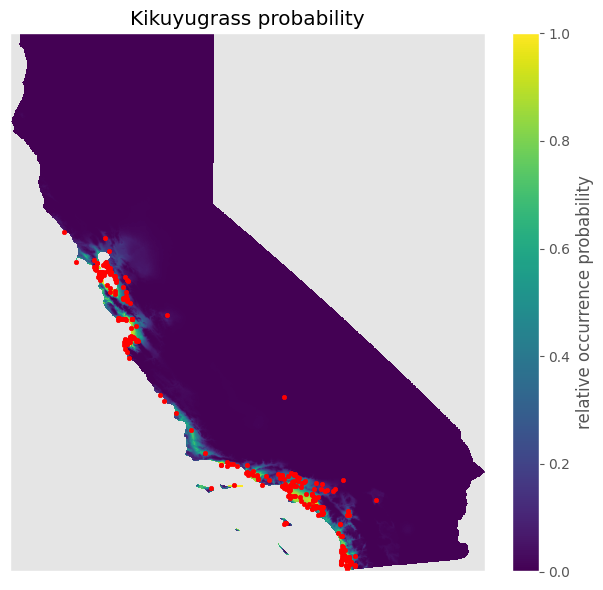

In [11]:
with rasterio.open(output_raster, "r") as src:
    fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)

    # Plot raster
    rasterio.plot.show(src, ax=ax)

    # Plot points
    filtered_df = data[data["class"] == 1]
    points = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(filtered_df["long"], filtered_df["lat"]),
        crs="EPSG:4326",
    )
    points.plot(ax=ax, color="red", markersize=10)

    ax.set_title("Kikuyugrass probability")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(ax.images[0], ax=ax, label="relative occurrence probability", pad=0.04)
    plt.tight_layout()

plt.show()

### Extrapolate to Hawaii extent

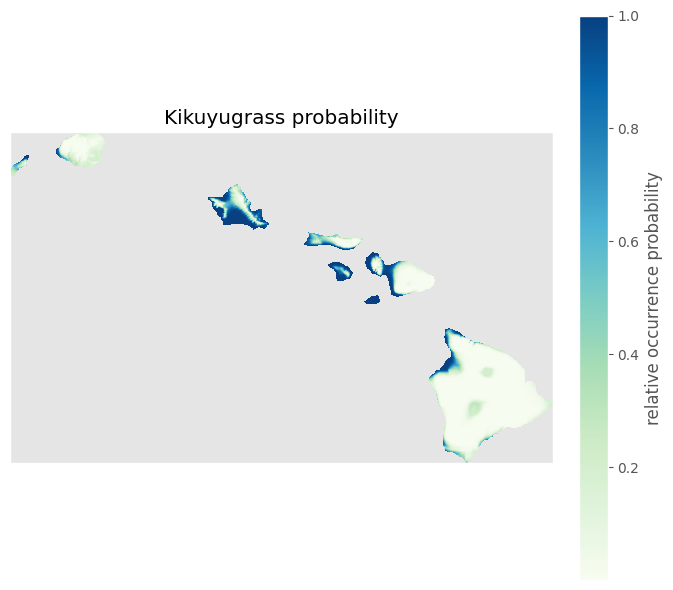

In [12]:
with rasterio.open("kikuyugrass_predictions_hawaii.tif") as src:
    pred = src.read(1, masked=True)
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap="GnBu")
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

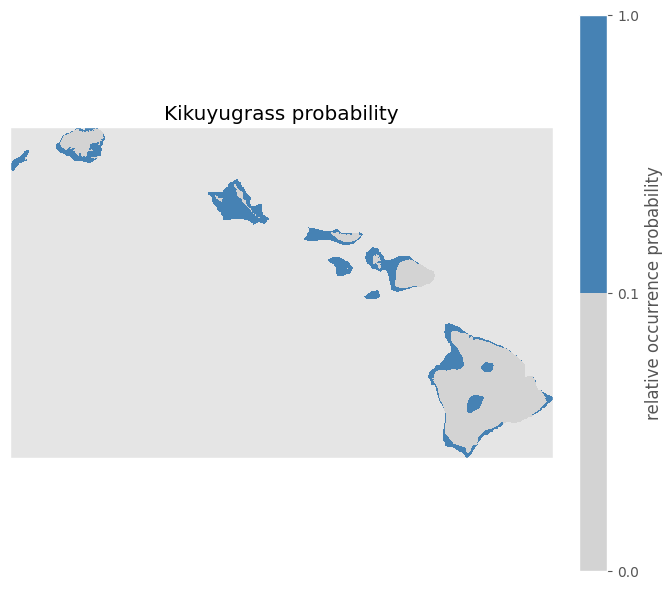

In [13]:
with rasterio.open("kikuyugrass_predictions_hawaii.tif") as src:
    pred = src.read(1, masked=True)

colors = ["lightgray", "steelblue"]
cmap = plt.cm.colors.ListedColormap(colors)
bounds = [0, 0.1, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap=cmap, norm=norm)
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

### Extrapolate to CONUS

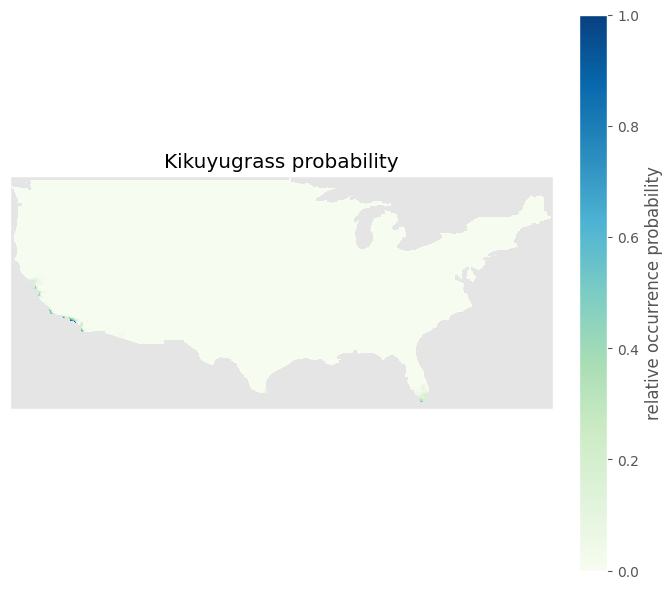

In [14]:
with rasterio.open("kikuyugrass_predictions_conus.tif") as src:
    pred = src.read(1, masked=True)
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap="GnBu")
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()

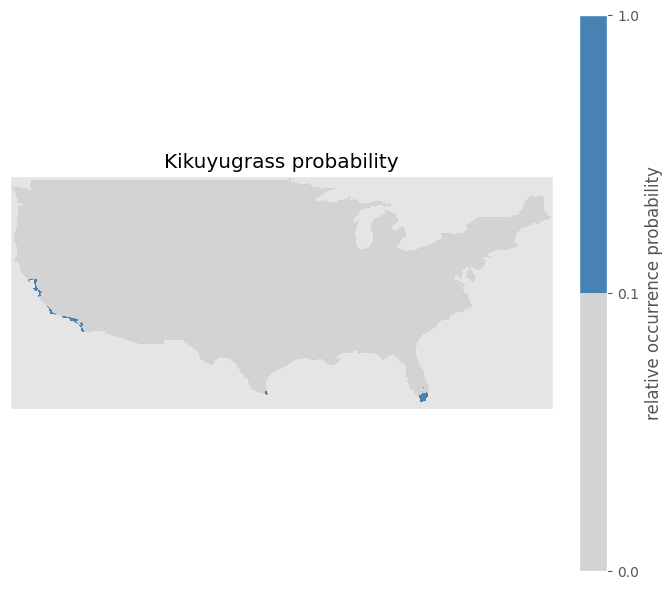

In [15]:
with rasterio.open("kikuyugrass_predictions_conus.tif") as src:
    pred = src.read(1, masked=True)

colors = ["lightgray", "steelblue"]
cmap = plt.cm.colors.ListedColormap(colors)
bounds = [0, 0.1, 1]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=100)
plot = ax.imshow(pred, cmap=cmap, norm=norm)
ax.set_title("Kikuyugrass probability")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(plot, ax=ax, label="relative occurrence probability", pad=0.04)
plt.tight_layout()